<a href="https://colab.research.google.com/github/vmendesmagalhaes/machine-learning/blob/main/Predicao_umidade_madeira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de variação do teor de umidade em madeira

**Autor:** Vitor Mendes Magalhaes

**Email:** vitor.mendes.magalhaes@gmail.com

**Data da última atualização:** 04/02/2023

Vamos iniciar carregando as bibliotecas necessárias.

In [ ]:
import pandas as pandas
import numpy as numpy
import matplotlib.pyplot as matplot
import seaborn as seaborn
from sklearn.model_selection import train_test_split as createDataPartition
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

O próximo passo é importar a planilha (arquivo .XLS).

In [ ]:
dados = pandas.read_excel('datasetjan23.xls')

Agora, vamos continuar pré-processando nossos dados. Vamos retirar os atributos que não são interessantes para a criação do modelos de aprendizado a serem aplicado.

Primeiro, vamos criar um novo atributo, chamado *PERCENTUAL*. Ele significa o percentual de perda (estorno) em relação ao total de entradas da pilha.

In [ ]:
dados['PERCENTUAL'] = (dados['ESTORNO'] * 100) / dados['TOT_ENTR']

Após a criação do novo atributo, vamos remover as instâncias de pilhas que não tiveram saídas de madeira. Em teoria, se não representam erro operacional, estas pilhas continuavam a receber cargas de madeira, ou ainda não estavam fechadas, no momento da captura dos dados.

Também vamos remover as instâncias que não tiveram cargas estornadas, ou seja, que em teoria não houve perda de umidade. Em cargas de madeira armazenadas ao ar livre (tecnicamente, chama-se "secagem natural"), nas condições dos dados capturados, sempre haverá perda de umidade.

In [ ]:
dados.drop(dados[dados['TOT_SAID'] == 0].index, inplace=True)
dados.drop(dados[dados['ESTORNO'] == 0].index, inplace=True)

Removidas as instâncias, vamos criar cópias do dataset original, que serão utilizadas para treinar diferentes modelos de resolução do problema utilizando aprendizado supervisionado: modelos de classificação (para diferentes classes) e de regressão.

In [ ]:
dfClassificacao = dados
dfRegressao = dados

Feito isso, vamos continuar pré-processando os dados, agora com uma seleção de características, enviesando os dados para ficarem de acordo com o tipo de aprendizado supervisionado ao que eles se propoem.

Para o modelo de regressão, vamos retirar a identificação da pilha (*PILHA*), o total de saídas (*TOT_SAID*), a diferença entre a entrada e a saída (*DIFERENCA*), as datas (*DATA_INICIO* e *DATA_FIM*) e a quantidade estornada (*ESTORNO*). Assim, já tornamos claro que a classe que se deseja predizer é o *PERCENTUAL* de perda de peso relativo à entrada total de madeira na pilha.

In [ ]:
dfRegressao = dfRegressao.drop(["PILHA", "TOT_SAID", "DIFERENCA", "DATA_INICIO", "DATA_FIM", "ESTORNO"], axis=1)

Já para a criação dos modelos de classificação, vamos criar um novo atributo, chamado *INTERVALOPERDA*. Os intervalos de perda nada mais são do que intervalos de percentuais de perda de peso, por ex.: entre 0% e 5% de perda; entre 5% e 10% de perda, e assim por diante, até o quanto os dados permitirem.

Para definir os melhores intervalos de percentuais de perda de peso, primeiro vamos analisar visualmente, através de três distintas ferramentas visuais de análise: um *boxplot*, um resumo do atributo *PERCENTUAL* (que irá ditar os intervalos), e um histograma com a frequência de instâncias com diferentes percentuais.

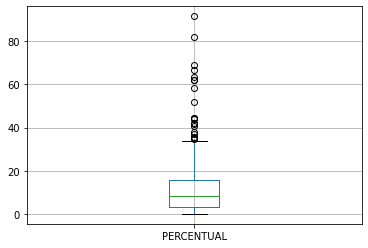

In [ ]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

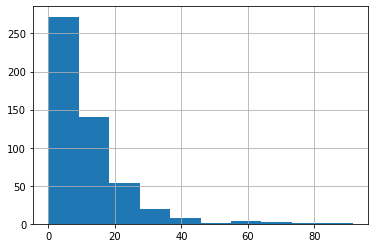

In [ ]:
dfClassificacao['PERCENTUAL'].hist()

In [ ]:
dfClassificacao.describe()

,PILHA,COMPRIMENTO,TEMP_MIN,TEMP_MAX,TEMP_MED,TEMP_PO,PRECIPITACAO,PATM_MED,UR_MIN,UR_MED,VENTO_MED,RAJ_MAX_MED,QTD_DIAS,TOT_ENTR,TOT_SAID,DIFERENCA,ESTORNO,PERCENTUAL
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,502.000000
mean,380.834661,5.191633,6.353386,30.933068,17.668108,13.021813,230.048207,1015.596673,29.844622,75.807032,3.020159,10.148426,82.864542,2.955402e+05,2.608087e+05,3.473146e+04,3.217752e+04,11.404791
std,201.004887,0.380277,4.468436,6.301451,3.514570,2.811104,204.907322,2.839966,9.870406,4.102414,0.423014,1.044224,70.283867,4.209043e+05,3.530809e+05,8.307838e+04,7.519074e+04,11.723297
min,1.000000,3.900000,1.900000,18.100000,11.640000,6.380000,0.000000,1005.890000,21.000000,64.360000,1.430000,5.700000,0.000000,1.144000e+04,3.030000e+03,-1.996000e+04,2.000000e+01,0.005657
25%,209.250000,5.200000,3.300000,26.700000,14.965000,11.017500,41.400000,1013.885000,21.000000,71.902500,2.700000,9.480000,22.000000,1.312050e+05,1.127950e+05,6.310000e+03,6.310000e+03,3.414372
50%,381.500000,5.200000,5.400000,32.500000,17.395000,12.805000,184.300000,1016.310000,26.000000,76.105000,3.155000,10.440000,69.000000,2.329100e+05,2.047900e+05,1.883000e+04,1.746000e+04,8.179170
75%,556.750000,5.200000,8.600000,34.400000,20.377500,14.797500,392.200000,1016.920000,36.000000,79.260000,3.260000,10.660000,133.750000,3.658750e+05,3.268445e+05,3.958000e+04,3.842550e+04,15.792322
max,722.000000,6.000000,24.000000,39.400000,26.930000,23.340000,1156.000000,1026.700000,70.000000,84.670000,4.630000,14.300000,425.000000,8.128820e+06,6.628260e+06,1.500560e+06,1.500560e+06,91.583333


Em uma breve análise, percebe-se que existem possíveis erros operacionais que podem gerar ruído no modelo de classificação, permitindo que sejam considerados outliers. Um exemplo claro é o percentual de perda. Existem percentuais que tendem a 100%, o que não ocorre neste processo; também existem percentuais que tendem a 0% - mesma situação.

Então, vamos retirar as instâncias com perdas acima de 40%.

In [ ]:
dfClassificacao = dfClassificacao.drop(dfClassificacao[dados['PERCENTUAL'] >= 40].index)

Após, vamos verificar novamente através do *boxplot*.

In [ ]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

Agora podemos retornar à criação do atributo *INTERVALOPERDA*, estabelecendo diferentes intervalos de percentuais de perda:

DESCRIÇÃO | INTERVALO
--- | ---
1 | menos de 10%
2 | entre 10% e 20%
3 | entre 20% e 30%
4 | mais de 30%

In [ ]:
for i, linha in dfClassificacao.iterrows():
  if (linha['PERCENTUAL'] <= 10):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 1;
  elif ((linha['PERCENTUAL'] > 10) and (linha['PERCENTUAL'] <= 20)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 2;
  elif ((linha['PERCENTUAL'] > 20) and (linha['PERCENTUAL'] <= 30)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 3;
  else:
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 4;

Criada a nossa classe (target), vamos remover os atributos que não serão importantes para a criação dos modelos de aprendizado - mais especificamente, da classificação. Nesse sentido, vamos remover a identificação da pilha (*PILHA*), as datas (*DATA_INICIO* e *DATA_FIM*, o peso de saída (*TOT_SAID*), a diferença entre os totais de entrada e saída (*DIFERENCA*), a quantidade estornada (*ESTORNO*) e o percentual (*PERCENTUAL*).

Assim, tornamos claro que a classe que se deseja predizer é o *INTERVALOPERDA*, recém criado, que contém o intervalo (em percentual) de perda de peso da madeira.

In [ ]:
dfClassificacao = dfClassificacao.drop(["PILHA", "DATA_INICIO", "DATA_FIM", "TOT_SAID", "DIFERENCA", "ESTORNO", "PERCENTUAL"], axis=1)

Depois de criado o atributo (classe) que será nosso target, e removidos os atributos que não serão preditores dos nossos modelos, vamos verificar o balanceamento do dataset.

In [ ]:
print(dfClassificacao['INTERVALOPERDA'].value_counts())

Podemos claramente observar que o maior número de instâncias está representado nas classes 1 e 2, ou seja, a grande maioria das pilhas presentes no dataset possui uma perda de peso (em razão da perda do teor de umidade) menor do que 20%.

Vamos verificar a integridade destes dados, analisando as perdas de umidade das pilhas em relação com a quantidade de dias em que as toras permaneceram armazenadas nas pilhas.



In [ ]:
print(dfClassificacao['QTD_DIAS'].describe())

Considerando, então, que em se tratando de perda do teor de umidade em madeira armazenada ao ar-livre (*natural drying*) 20% é um percentual pequeno, pode-se depreender facilmente que estas toras, em razão da grande quantidade de dias média de vida das pilhas (81 dias), já haviam sido cortadas há mais tempo.

Como existem atributos preditores não-numéricos, precisamos tratá-los, transformando em atributos numéricos para que possamos prosseguir com o treinamento dos modelos de aprendizado (no Weka, no R e em outros ambientes/linguagens, esta transformação não se faz necessária, mas é preciso analisar possíveis diferenças no resultado da predição).

Vamos fazer o *one-hot-encoding* para os atributos categóricos que não possuem qualquer necessidade de ordenação, como produto, casca e espécie.

In [ ]:
atributos_a_codificar = ['PRODUTO', 'CASCA', 'ESPECIE', 'DIAMETRO']

atributos_codificados = pandas.get_dummies(dfClassificacao[atributos_a_codificar])

dfClassificacao = dfClassificacao.drop(atributos_a_codificar, axis=1).join(atributos_codificados)

O dataset ainda não foi particionado, e a tendência é que as partições reproduzam o comportamento geral do dataset. Então, vamos particioná-lo antes de resolver o problema do desbalanceamento das classes.

In [ ]:
dados_treino, dados_teste, classe_treino, classe_teste = createDataPartition(dfClassificacao, dfClassificacao['INTERVALOPERDA'], test_size=0.25)


In [ ]:
#classe_teste.head(10)

Sendo assim, podemos proceder com o treinamento dos modelos. Agora, temos o dataset particionado e já enviesado para o aprendizado supervisionado - classificação. Vamos, então, instanciar o modelo de classificação utilizando o algoritmo *Random Forest* (RF).

In [ ]:
rf = RandomForestClassifier()

Instanciado o modelo, é momento de treinar o modelo de classificação utilizando o algoritmo *Random Forest* (RF).

In [ ]:
rf.fit(dados_treino, classe_treino)

RandomForestClassifier()

Estando o modelo treinado (utilizando tanto os dados de treino quanto a classe de treino), o próximo passo é verificar as predições, ou seja, o quê de fato o modelo criado foi capaz de aprender com os dados dispostos.

In [ ]:
predicoes = rf.predict(dados_teste)

Guardadas as predições em uma variável, vamos verificar através de uma matriz de confusão os resultados das predições do modelo de aprendizado utilizando classificação com RF.

In [ ]:
cm = confusion_matrix(classe_teste, predicoes)

cm

array([[70,  0,  0,  0],
       [ 0, 37,  0,  0],
       [ 0,  3,  5,  0],
       [ 0,  1,  6,  0]])

Observando a matriz de confusão acima, pode-se observar a assertividade do método escolhido. Mas precisamos tornar a informação mais clara. Para isso, vamos utilizar algumas métricas, começando pela acurácia do modelo, ou seja, o quanto, em percentual, que o modelo é capaz de acertar suas predições (sempre com base nos dados que o modelo teve à disposição).

In [ ]:
print("Acurácia:", metrics.accuracy_score(classe_teste, predicoes))

Acurácia: 0.9180327868852459


É importante ter em mente que, por mais que a acurácia seja a proporção de predições corretas em relação ao total de predições, ela é uma métrica simples, ou seja, nem sempre pode ser a métrica a mais adequada - especialmente em conjuntos de dados desbalanceados.

<BarContainer object of 32 artists>

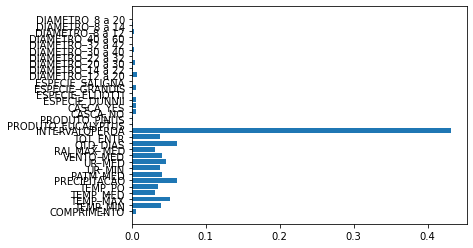

In [ ]:
# Calcule a importância das features
importance = rf.feature_importances_

importance

# Crie um gráfico para visualizar a importância das features
matplot.barh(dados_teste.columns, importance)
#matplot.xlabel('Importância da Feature')
#matplot.ylabel('Feature')
#matplot.title('Importância das Features no Modelo Random Forest')

# Mostre o gráfico
#matplot.show()